In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Amazon Review Sentiment Analysis Model

This notebook builds a Keras neural network model for sentiment analysis on Amazon product reviews.

**Objective:** Classify reviews as Positive (1) or Negative (0)
**Dataset:** Amazon Product Reviews
**Features:** Review body text
**Output:** Sentiment (binary classification)

In [2]:
# Load and Explore Dataset
df = pd.read_csv('Amazon-Product-Reviews - Amazon Product Review (1).csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

Dataset Shape: (30846, 16)

First few rows:
  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     11555559  R1QXC7AHHJBQ3O  B00IKPX4GY         2693241   
1          US     31469372  R175VSRV6ZETOP  B00IKPYKWG         2693241   
2          US     26843895  R2HRFF78MWGY19  B00IKPW0UA         2693241   
3          US     19844868   R8Q39WPKYVSTX  B00LCHSHMS         2693241   
4          US      1189852  R3RL4C8YP2ZCJL  B00IKPZ5V6         2693241   

                           product_title product_category  star_rating  \
0  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            5   
1  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            3   
2  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            5   
3  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            4   
4  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            5   

   helpful_votes  total_votes vine verified_purchase  \
0         

In [3]:
# Data Preprocessing
# Remove rows with missing review_body or sentiment
df = df.dropna(subset=['review_body', 'sentiment'])

# Remove duplicates
df = df.drop_duplicates(subset=['review_body'], keep='first')

# Convert sentiment to binary (ensure 0 and 1 values)
df['sentiment'] = df['sentiment'].astype(int)

print(f"Dataset size after cleaning: {len(df)}")
print(f"\nSentiment distribution after cleaning:")
print(df['sentiment'].value_counts())
print(f"\nPercentages:")
print(df['sentiment'].value_counts(normalize=True) * 100)

Dataset size after cleaning: 27761

Sentiment distribution after cleaning:
sentiment
1    22716
0     5045
Name: count, dtype: int64

Percentages:
sentiment
1    81.827024
0    18.172976
Name: proportion, dtype: float64


In [5]:
# Text Feature Extraction using CountVectorizer
# This converts text into numerical features

# Create separate vectorizers for title and body (as in the project structure)
from sklearn.feature_extraction.text import CountVectorizer

# Fill NaN values in review_headline with empty strings
df['review_headline'] = df['review_headline'].fillna('')

# Vectorizer for review body
cv_body = CountVectorizer(max_features=1000, stop_words='english')
X_body = cv_body.fit_transform(df['review_body']).toarray()

# Vectorizer for review headline
cv_title = CountVectorizer(max_features=100, stop_words='english')
X_title = cv_title.fit_transform(df['review_headline']).toarray()

# Combine features
X = np.hstack([X_title, X_body])
y = df['sentiment'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Title features: {X_title.shape[1]}")
print(f"Body features: {X_body.shape[1]}")
print(f"Total features: {X.shape[1]}")

# Save vectorizers for later use in the app
import joblib
joblib.dump(cv_title, 'cv1.pkl')
joblib.dump(cv_body, 'cv2.pkl')
print("\nVectorizers saved: cv1.pkl, cv2.pkl")

Feature matrix shape: (27761, 1100)
Title features: 100
Body features: 1000
Total features: 1100

Vectorizers saved: cv1.pkl, cv2.pkl


In [8]:
# Balance Dataset using SMOTE (Synthetic Minority Over-sampling Technique)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

print("Balancing dataset...")
print(f"Before balancing - Sentiment distribution:")
print(pd.Series(y).value_counts())
positive_count = (y == 1).sum()
negative_count = (y == 0).sum()
print(f"Class ratio (Positive/Negative): {positive_count / negative_count:.2f}")

# Balance the dataset using SMOTE
# SMOTE creates synthetic samples for minority class (negative reviews)
# This will make positive and negative classes equal
smote = SMOTE(random_state=42, k_neighbors=5)
X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"\nAfter balancing - Sentiment distribution:")
print(pd.Series(y_balanced).value_counts())
positive_count_bal = (y_balanced == 1).sum()
negative_count_bal = (y_balanced == 0).sum()
print(f"Class ratio (Positive/Negative): {positive_count_bal / negative_count_bal:.2f}")
print(f"New dataset size: {len(X_balanced)} (was {len(X)})")

# Use balanced data for training
X = X_balanced
y = y_balanced

Balancing dataset...
Before balancing - Sentiment distribution:
1    22716
0     5045
Name: count, dtype: int64
Class ratio (Positive/Negative): 4.50

After balancing - Sentiment distribution:
1    22716
0    22716
Name: count, dtype: int64
Class ratio (Positive/Negative): 1.00
New dataset size: 45432 (was 27761)


In [9]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set sentiment distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest set sentiment distribution:")
print(pd.Series(y_test).value_counts())

Training set size: 36345
Test set size: 9087

Training set sentiment distribution:
1    18173
0    18172
Name: count, dtype: int64

Test set sentiment distribution:
0    4544
1    4543
Name: count, dtype: int64


In [10]:
# Build Keras Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

# Display model architecture
print("Model Architecture:")
model.summary()

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       140,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,297 (591.00 KB)

 Trainable params: 151,297 (591.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the Model
print("Training the model...")
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

print("\nTraining completed!")

Training the model...
Epoch 1/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8774 - loss: 0.3095 - precision: 0.8665 - recall: 0.8916 - val_accuracy: 0.9106 - val_loss: 0.2299 - val_precision: 0.9212 - val_recall: 0.9001
Epoch 2/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9247 - loss: 0.2050 - precision: 0.9193 - recall: 0.9307 - val_accuracy: 0.9135 - val_loss: 0.2268 - val_precision: 0.9087 - val_recall: 0.9213
Epoch 3/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9406 - loss: 0.1633 - precision: 0.9357 - recall: 0.9460 - val_accuracy: 0.9179 - val_loss: 0.2411 - val_precision: 0.9146 - val_recall: 0.9238
Epoch 4/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9515 - loss: 0.1351 - precision: 0.9491 - recall: 0.9538 - val_accuracy: 0.9210 - val_loss: 0.2680 - val_precision: 0.9164 - val_recall: 0.9284

Training completed!


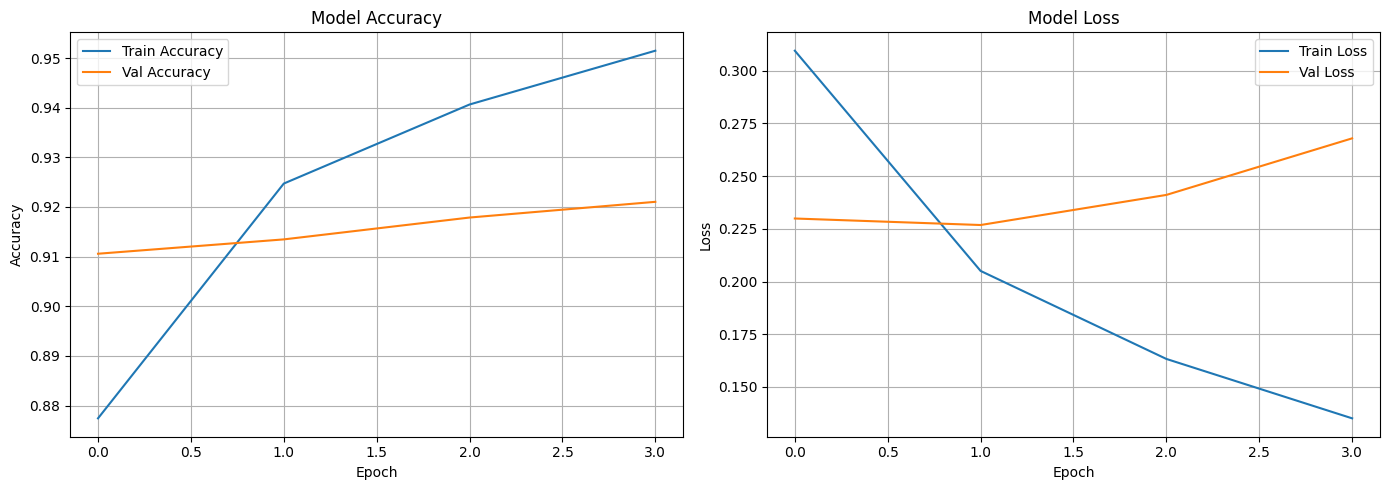

Training history visualization completed!


In [12]:
# Plot Training History
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training history visualization completed!")

In [13]:
# Evaluate Model on Test Set
print("Evaluating model on test set...")
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n{'='*50}")
print(f"{'Model Performance Metrics':<30}")
print(f"{'='*50}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"{'='*50}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Classification Report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Evaluating model on test set...
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model Performance Metrics     
Accuracy:  0.9154
Precision: 0.9102
Recall:    0.9216
F1-Score:  0.9159

Confusion Matrix:
[[4131  413]
 [ 356 4187]]

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.91      0.91      4544
    Positive       0.91      0.92      0.92      4543

    accuracy                           0.92      9087
   macro avg       0.92      0.92      0.92      9087
weighted avg       0.92      0.92      0.92      9087



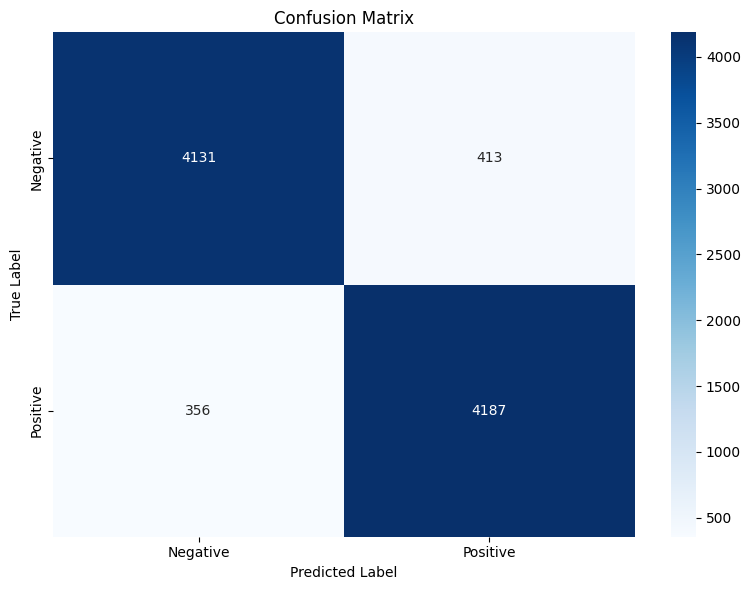

In [14]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [15]:
# Save the Trained Model
model.save('model.keras')
print("✓ Model saved as 'model.keras'")
print(f"\nModel Summary:")
print(f"- Total parameters: {model.count_params():,}")
print(f"- Input shape: {model.input_shape}")
print(f"- Output shape: {model.output_shape}")

✓ Model saved as 'model.keras'

Model Summary:
- Total parameters: 151,297
- Input shape: (None, 1100)
- Output shape: (None, 1)


In [17]:
# Test the Model with Sample Reviews
def predict_sentiment(review_text, title_text=""):
    """
    Predict sentiment for a given review.
    
    Args:
        review_text: The review body text
        title_text: The review title text
        
    Returns:
        dict with sentiment label and confidence score
    """
    # Transform using the saved vectorizers
    title_features = cv_title.transform([title_text]).toarray()
    body_features = cv_body.transform([review_text]).toarray()
    features = np.hstack([title_features, body_features])
    
    # Predict
    prediction = model.predict(features, verbose=0)[0][0]
    sentiment = 'POSITIVE' if prediction > 0.5 else 'NEGATIVE'
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return {
        'sentiment': sentiment,
        'confidence': float(confidence),
        'raw_score': float(prediction)
    }

# Test with sample reviews
test_reviews = [
    ("This product is amazing!", "Great quality"),
    ("Terrible product, waste of money", "Worst purchase"),
    ("It's okay, nothing special", "Average"),
    ("Love it! Best product ever", "Five stars"),
]

print("Sample Predictions:")
print("=" * 70)
for review, title in test_reviews:
    result = predict_sentiment(review, title)
    print(f"Title: {title}")
    print(f"Review: {review}")
    print(f"Prediction: {result['sentiment']} ({result['confidence']:.2%})")
    print("-" * 70)

Sample Predictions:
Title: Great quality
Review: This product is amazing!
Prediction: POSITIVE (96.79%)
----------------------------------------------------------------------
Title: Worst purchase
Review: Terrible product, waste of money
Prediction: NEGATIVE (99.83%)
----------------------------------------------------------------------
Title: Average
Review: It's okay, nothing special
Prediction: NEGATIVE (99.14%)
----------------------------------------------------------------------
Title: Five stars
Review: Love it! Best product ever
Prediction: POSITIVE (99.20%)
----------------------------------------------------------------------
